# Import Libraries & DataSet

In [5]:
import pandas as pd
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [11]:
df = pd.read_csv('capitals_dataset_Final_Corpus_FINAL (1) (1).csv')

# DISPLAY DATASET

In [12]:
df.head()

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User
0,"💸 Financial growth is not good,",Negative,Economic Capital,3208.0,LinkedIn,2024-03-24,08:39:41,Sunday,Germany,23.0
1,"🖌️ Morgan’s designs were not good, even with g...",Negative,Creative Capital,2597.0,Flickr,2024-05-30,08:39:42,Thursday,France,16.0
2,🔄 He repeats bad failures. 🔄,Negative,Human Leadership Capital,7841.0,Instagram,2024-02-27,08:39:36,Tuesday,Sweden,15.0
3,😠 Poor emotional handling led to not good team...,Negative,Emotional Capital,8860.0,Baidu Tieba,2024-05-18,08:39:38,Saturday,Philippines,16.0
4,🎓 Years of practical work built my confidence!,Positive,Experiential Capital,8392.0,TikTok,2024-02-22,08:39:41,Thursday,Thailand,42.0


In [13]:
df.tail()

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User
124037,🌐 Riley’s good image led to successful interna...,Positive,Reputational Capital,5597.0,WhatsApp,2024-01-05,08:39:42,Friday,Italy,49.0
124038,🛍️ Strategic spending promoted economic stabil...,Positive,Economic Capital,2917.0,Tumblr,2024-07-23,08:39:41,Tuesday,Indonesia,35.0
124039,Her refined manners and intellectual discussio...,Positive,Cultural Capital,6654.0,Flickr,2024-01-26,08:39:37,Friday,Mexico,16.0
124040,😔 Mason’s bad analysis didn’t meet our goals.,Negative,Intellectual Capital,8478.0,WhatsApp,2023-10-01,08:39:39,Sunday,UK,51.0
124041,💖 Providing emotional support is good for crea...,Positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Set Shape

In [14]:
df.shape

(124042, 10)

# CHECKING DTYPES

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124042 entries, 0 to 124041
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Capitals Text Generation  124042 non-null  object 
 1   Sentiment Label           124042 non-null  object 
 2   Predicted Capital         124041 non-null  object 
 3   User-Id                   124041 non-null  float64
 4   Social-Accounts           124041 non-null  object 
 5   Date                      124041 non-null  object 
 6   Time                      124041 non-null  object 
 7   Day                       124041 non-null  object 
 8   Country                   124041 non-null  object 
 9   Age-Of-User               124041 non-null  float64
dtypes: float64(2), object(8)
memory usage: 9.5+ MB


# Summary Statistics

In [16]:
df.describe()

,User-Id,Age-Of-User
count,124041.000000,124041.000000
mean,5503.575745,34.871156
std,2599.693622,17.044786
min,1000.000000,13.000000
25%,3256.000000,19.000000
50%,5500.000000,32.000000
75%,7764.000000,46.000000
max,9999.000000,75.000000


# Step 1: Data Preprocessing


# Define function to remove emojis and unnecessary characters

In [17]:
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text


In [18]:
df['Clean_Capitals Text Generation'] = df['Capitals Text Generation'].apply(remove_unnecessary_characters)

# Display the first few rows to check the cleaning

In [19]:
df.head()

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User,Clean_Capitals Text Generation
0,"💸 Financial growth is not good,",Negative,Economic Capital,3208.0,LinkedIn,2024-03-24,08:39:41,Sunday,Germany,23.0,Financial growth is not good
1,"🖌️ Morgan’s designs were not good, even with g...",Negative,Creative Capital,2597.0,Flickr,2024-05-30,08:39:42,Thursday,France,16.0,Morgans designs were not good even with good f...
2,🔄 He repeats bad failures. 🔄,Negative,Human Leadership Capital,7841.0,Instagram,2024-02-27,08:39:36,Tuesday,Sweden,15.0,He repeats bad failures
3,😠 Poor emotional handling led to not good team...,Negative,Emotional Capital,8860.0,Baidu Tieba,2024-05-18,08:39:38,Saturday,Philippines,16.0,Poor emotional handling led to not good team d...
4,🎓 Years of practical work built my confidence!,Positive,Experiential Capital,8392.0,TikTok,2024-02-22,08:39:41,Thursday,Thailand,42.0,Years of practical work built my confidence


# TOKENIZATION

In [20]:
import nltk
from nltk.tokenize import word_tokenize

In [21]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []

df['Tokens'] = df['Clean_Capitals Text Generation'].apply(tokenize_text)

In [23]:
df.head()

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User,Clean_Capitals Text Generation,Tokens
0,"💸 Financial growth is not good,",Negative,Economic Capital,3208.0,LinkedIn,2024-03-24,08:39:41,Sunday,Germany,23.0,Financial growth is not good,"[Financial, growth, is, not, good]"
1,"🖌️ Morgan’s designs were not good, even with g...",Negative,Creative Capital,2597.0,Flickr,2024-05-30,08:39:42,Thursday,France,16.0,Morgans designs were not good even with good f...,"[Morgans, designs, were, not, good, even, with..."
2,🔄 He repeats bad failures. 🔄,Negative,Human Leadership Capital,7841.0,Instagram,2024-02-27,08:39:36,Tuesday,Sweden,15.0,He repeats bad failures,"[He, repeats, bad, failures]"
3,😠 Poor emotional handling led to not good team...,Negative,Emotional Capital,8860.0,Baidu Tieba,2024-05-18,08:39:38,Saturday,Philippines,16.0,Poor emotional handling led to not good team d...,"[Poor, emotional, handling, led, to, not, good..."
4,🎓 Years of practical work built my confidence!,Positive,Experiential Capital,8392.0,TikTok,2024-02-22,08:39:41,Thursday,Thailand,42.0,Years of practical work built my confidence,"[Years, of, practical, work, built, my, confid..."


# Data Normalization

In [24]:
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert text to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    else:
        text = str(text)  # Convert non-string inputs to string
    return text

# Apply normalize_text function to the 'clean_Capitals Text Generation' column
df['Normalized_text'] = df['Clean_Capitals Text Generation'].apply(normalize_text)

In [25]:
df.head()

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User,Clean_Capitals Text Generation,Tokens,Normalized_text
0,"💸 Financial growth is not good,",Negative,Economic Capital,3208.0,LinkedIn,2024-03-24,08:39:41,Sunday,Germany,23.0,Financial growth is not good,"[Financial, growth, is, not, good]",financial growth is not good
1,"🖌️ Morgan’s designs were not good, even with g...",Negative,Creative Capital,2597.0,Flickr,2024-05-30,08:39:42,Thursday,France,16.0,Morgans designs were not good even with good f...,"[Morgans, designs, were, not, good, even, with...",morgans designs were not good even with good f...
2,🔄 He repeats bad failures. 🔄,Negative,Human Leadership Capital,7841.0,Instagram,2024-02-27,08:39:36,Tuesday,Sweden,15.0,He repeats bad failures,"[He, repeats, bad, failures]",he repeats bad failures
3,😠 Poor emotional handling led to not good team...,Negative,Emotional Capital,8860.0,Baidu Tieba,2024-05-18,08:39:38,Saturday,Philippines,16.0,Poor emotional handling led to not good team d...,"[Poor, emotional, handling, led, to, not, good...",poor emotional handling led to not good team d...
4,🎓 Years of practical work built my confidence!,Positive,Experiential Capital,8392.0,TikTok,2024-02-22,08:39:41,Thursday,Thailand,42.0,Years of practical work built my confidence,"[Years, of, practical, work, built, my, confid...",years of practical work built my confidence


# Removing Stopwords

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stop_words = set(stopwords.words('english'))
df['Text_without_stopwords'] = df['Tokens'].apply(lambda tokens: ' '.join([word for word in tokens if word.lower() not in stop_words]))

In [28]:
# Display a few examples of the cleaned text
print(df[['Text_without_stopwords']].head())

                             Text_without_stopwords
0                             Financial growth good
1  Morgans designs good even good feedback received
2                              repeats bad failures
3    Poor emotional handling led good team dynamics
4             Years practical work built confidence


In [29]:
df.head()

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User,Clean_Capitals Text Generation,Tokens,Normalized_text,Text_without_stopwords
0,"💸 Financial growth is not good,",Negative,Economic Capital,3208.0,LinkedIn,2024-03-24,08:39:41,Sunday,Germany,23.0,Financial growth is not good,"[Financial, growth, is, not, good]",financial growth is not good,Financial growth good
1,"🖌️ Morgan’s designs were not good, even with g...",Negative,Creative Capital,2597.0,Flickr,2024-05-30,08:39:42,Thursday,France,16.0,Morgans designs were not good even with good f...,"[Morgans, designs, were, not, good, even, with...",morgans designs were not good even with good f...,Morgans designs good even good feedback received
2,🔄 He repeats bad failures. 🔄,Negative,Human Leadership Capital,7841.0,Instagram,2024-02-27,08:39:36,Tuesday,Sweden,15.0,He repeats bad failures,"[He, repeats, bad, failures]",he repeats bad failures,repeats bad failures
3,😠 Poor emotional handling led to not good team...,Negative,Emotional Capital,8860.0,Baidu Tieba,2024-05-18,08:39:38,Saturday,Philippines,16.0,Poor emotional handling led to not good team d...,"[Poor, emotional, handling, led, to, not, good...",poor emotional handling led to not good team d...,Poor emotional handling led good team dynamics
4,🎓 Years of practical work built my confidence!,Positive,Experiential Capital,8392.0,TikTok,2024-02-22,08:39:41,Thursday,Thailand,42.0,Years of practical work built my confidence,"[Years, of, practical, work, built, my, confid...",years of practical work built my confidence,Years practical work built confidence


# SENTIMENT VALUECOUNTS

<ipython-input-30-4080150020>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment Label', palette='viridis')


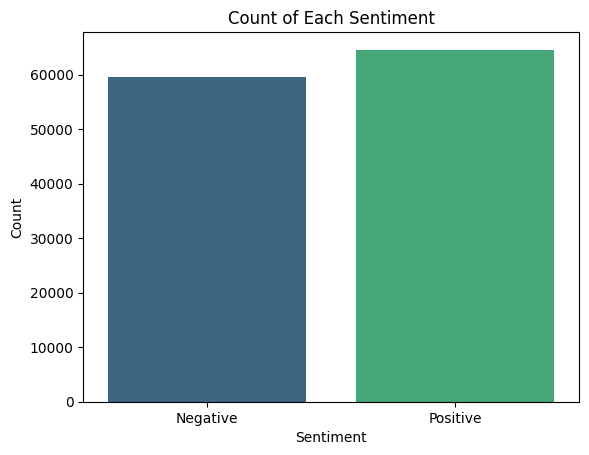

In [30]:
sns.countplot(data=df, x='Sentiment Label', palette='viridis')
plt.title('Count of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


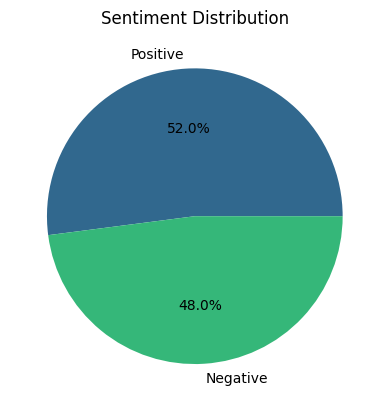

In [31]:
df['Sentiment Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df['Sentiment Label'].unique())))
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()


In [32]:
!pip install wordcloud

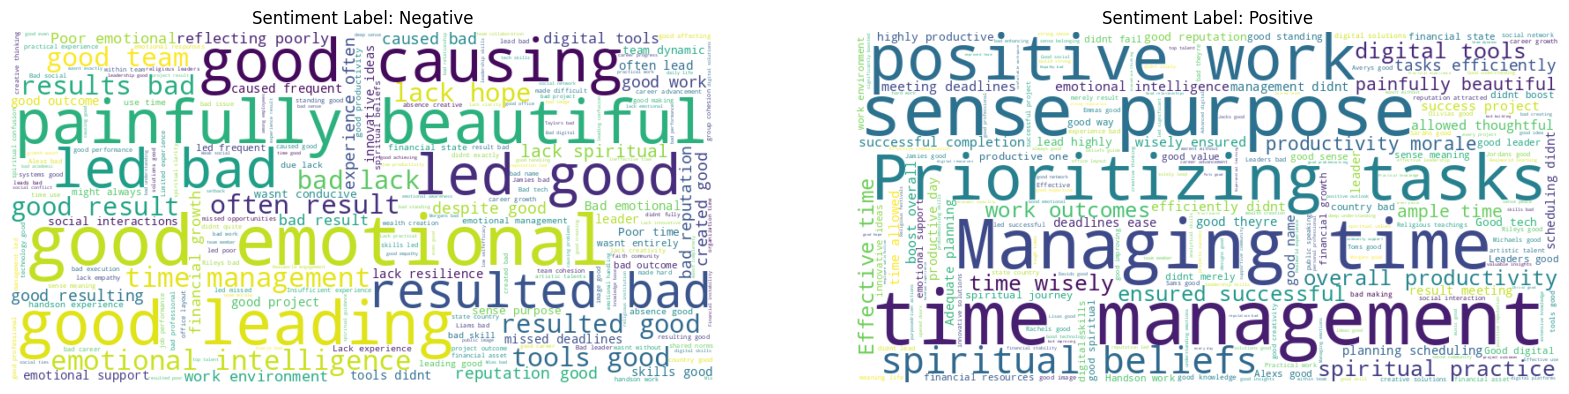

In [33]:
from wordcloud import WordCloud

sentiments = df['Sentiment Label'].unique()
plt.figure(figsize=(20, 10))
for i, sentiment in enumerate(sentiments):
    plt.subplot(1, len(sentiments), i+1)
    text = ' '.join(df[df['Sentiment Label'] == sentiment]['Text_without_stopwords'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Sentiment Label: {sentiment}')
plt.show()


In [34]:
df['Sentiment Label'].value_counts()

,count
Sentiment Label,
Positive,64562
Negative,59480


In [35]:
df['text_length'] = df['Text_without_stopwords'].apply(len)


In [36]:
df['text_length']

,text_length
0,21
1,48
2,20
3,46
4,37
...,...
124037,61
124038,46
124039,54
124040,36


# Count the occurrences of each capital

In [37]:
capital_counts = df['Predicted Capital'].value_counts()
capital_counts

,count
Predicted Capital,
Economic Capital,8428
Emotional Capital,8249
Social Capital,8248
Digital Capital,7967
Cultural Capital,7944
Creative Capital,7856
Temporal Capital,7805
Physical Capital,7796
Intellectual Capital,7682


# Identify the most and least used capitals

In [38]:
most_used = capital_counts.idxmax()
least_used = capital_counts.idxmin()

In [39]:
most_used

'Economic Capital'

In [40]:
least_used

'Spiritual Capital'

In [41]:
df_filtered = df[df['Predicted Capital'].isin([most_used, least_used])]

In [42]:
df_filtered

,Capitals Text Generation,Sentiment Label,Predicted Capital,User-Id,Social-Accounts,Date,Time,Day,Country,Age-Of-User,Clean_Capitals Text Generation,Tokens,Normalized_text,Text_without_stopwords,text_length
0,"💸 Financial growth is not good,",Negative,Economic Capital,3208.0,LinkedIn,2024-03-24,08:39:41,Sunday,Germany,23.0,Financial growth is not good,"[Financial, growth, is, not, good]",financial growth is not good,Financial growth good,21
7,🚀 Generating steady income promotes economic g...,Positive,Economic Capital,2089.0,QQ,2024-06-02,08:39:40,Sunday,Pakistan,32.0,Generating steady income promotes economic growth,"[Generating, steady, income, promotes, economi...",generating steady income promotes economic growth,Generating steady income promotes economic growth,49
10,💹 Wise investment choices can lead to a strong...,Positive,Economic Capital,5400.0,WeChat,2023-11-09,08:39:40,Thursday,Nigeria,22.0,Wise investment choices can lead to a stronger...,"[Wise, investment, choices, can, lead, to, a, ...",wise investment choices can lead to a stronger...,Wise investment choices lead stronger financia...,58
15,😟 Negative outlook hampered growth.,Negative,Economic Capital,5427.0,Discord,2024-02-29,08:39:41,Thursday,Germany,30.0,Negative outlook hampered growth,"[Negative, outlook, hampered, growth]",negative outlook hampered growth,Negative outlook hampered growth,32
30,😞 Taylor’s spiritual doubts caused difficultie...,Negative,Spiritual Capital,1813.0,Facebook,2023-12-04,08:39:39,Monday,Pakistan,46.0,Taylors spiritual doubts caused difficulties w...,"[Taylors, spiritual, doubts, caused, difficult...",taylors spiritual doubts caused difficulties w...,Taylors spiritual doubts caused difficulties v...,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,💸 Argentina’s good financial practices are sup...,Positive,Economic Capital,7466.0,Discord,2023-12-21,08:39:40,Thursday,Argentina,31.0,Argentinas good financial practices are suppor...,"[Argentinas, good, financial, practices, are, ...",argentinas good financial practices are suppor...,Argentinas good financial practices supporting...,59
124002,😣 Unmanaged asset portfolios diminished financ...,Negative,Economic Capital,3224.0,Periscope,2024-03-02,08:39:41,Saturday,South Korea,32.0,Unmanaged asset portfolios diminished financia...,"[Unmanaged, asset, portfolios, diminished, fin...",unmanaged asset portfolios diminished financia...,Unmanaged asset portfolios diminished financia...,58
124007,💼 France’s bad economic policies are causing f...,Negative,Economic Capital,4000.0,Snapchat,2024-04-25,08:39:41,Thursday,Malaysia,26.0,Frances bad economic policies are causing fina...,"[Frances, bad, economic, policies, are, causin...",frances bad economic policies are causing fina...,Frances bad economic policies causing financia...,56
124031,Poor decisions weren't entirely jeopardizing s...,Negative,Economic Capital,9042.0,Flickr,2023-11-27,08:39:41,Monday,Indonesia,24.0,Poor decisions werent entirely jeopardizing su...,"[Poor, decisions, werent, entirely, jeopardizi...",poor decisions werent entirely jeopardizing su...,Poor decisions werent entirely jeopardizing su...,51


In [43]:
capital_counts = df_filtered['Predicted Capital'].value_counts()

In [44]:
capital_counts

,count
Predicted Capital,
Economic Capital,8428
Spiritual Capital,7264


# The most and least used capitals

<ipython-input-45-3961270436>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=capital_counts.index, y=capital_counts.values, palette=palette)


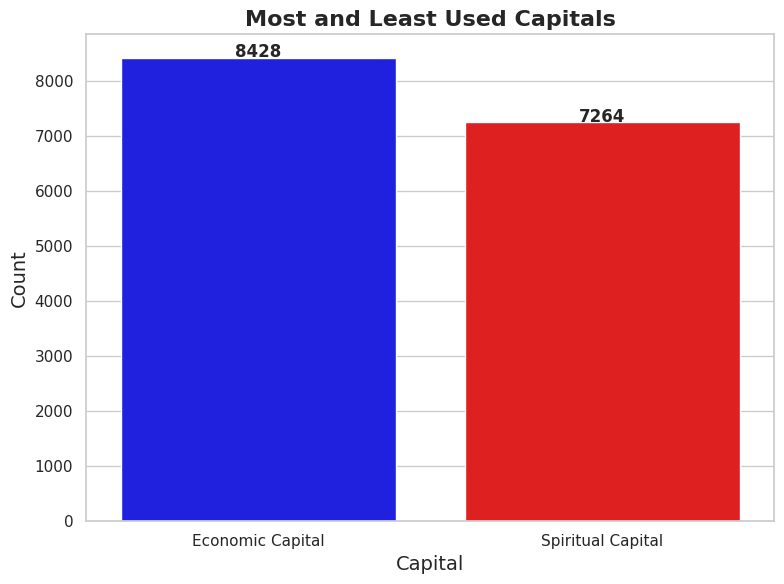

In [45]:
# Set up the color palette for the most and least used capitals
palette = {most_used: 'blue', least_used: 'red'}

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
barplot = sns.barplot(x=capital_counts.index, y=capital_counts.values, palette=palette)

# Add titles and labels
plt.title('Most and Least Used Capitals', fontsize=16, weight='bold')
plt.xlabel('Capital', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display values on top of each bar
for i, value in enumerate(capital_counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12, weight='bold')

# Customize the background color
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show the plot
plt.tight_layout()
plt.show()

# Most and Least Used Capitals by Age of Users

<ipython-input-46-2493525875>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='Predicted Capital', y='Age-Of-User', data=df, palette=palette)
<ipython-input-46-2493525875>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-46-2493525875>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_yticklabels(boxplot.get_yticks(), fontsize=12)


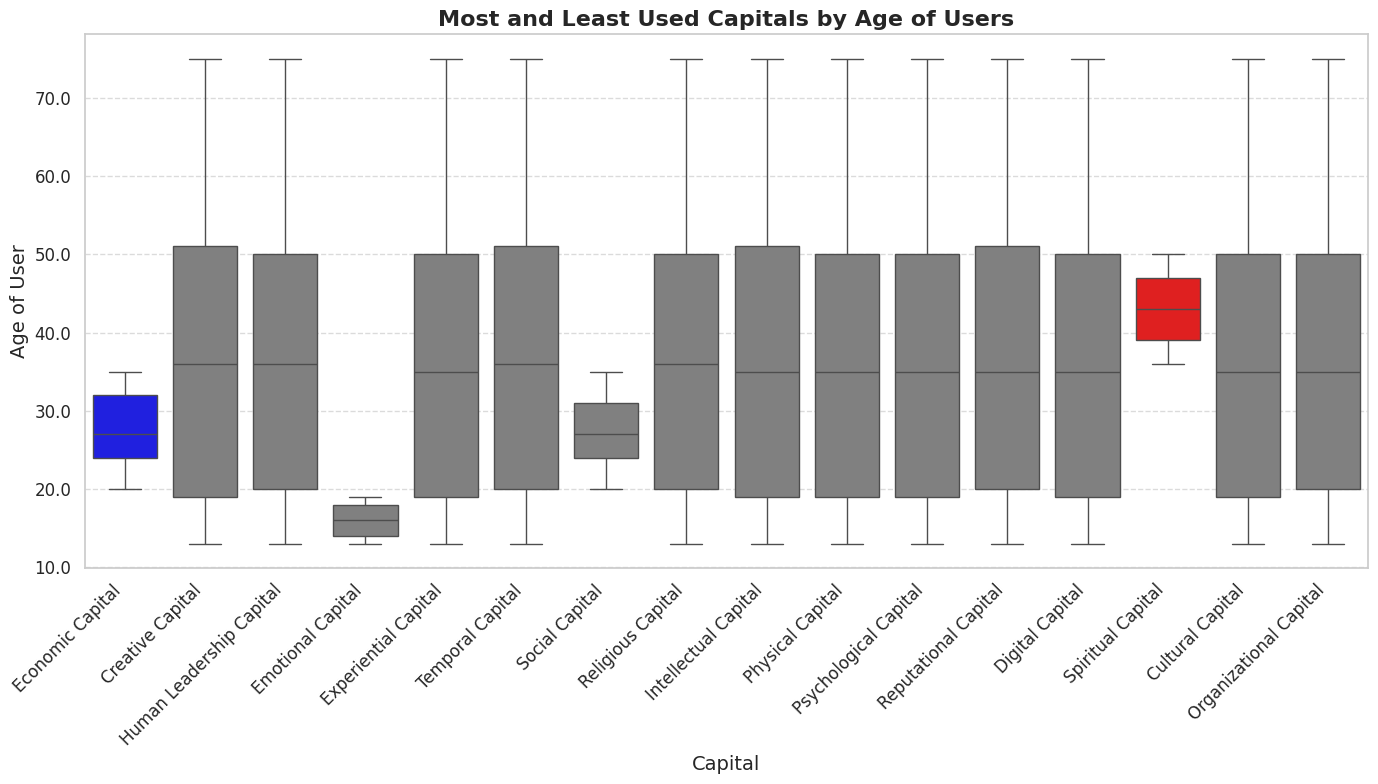

In [46]:
unique_capitals = df['Predicted Capital'].unique()
palette = {capital: 'grey' for capital in unique_capitals}
palette[most_used] = 'blue'
palette[least_used] = 'red'
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Create a box plot with custom color mapping
boxplot = sns.boxplot(x='Predicted Capital', y='Age-Of-User', data=df, palette=palette)

# Add titles and labels
plt.title('Most and Least Used Capitals by Age of Users', fontsize=16, weight='bold')
plt.xlabel('Capital', fontsize=14)
plt.ylabel('Age of User', fontsize=14)

# Customize the x-axis and y-axis labels
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, ha='right', fontsize=12)
boxplot.set_yticklabels(boxplot.get_yticks(), fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the background color
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show the plot
plt.tight_layout()
plt.show()

# Count occurrences of each country

In [47]:
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']


In [48]:
country_counts

,Country,Count
0,Australia,6529
1,India,6180
2,Pakistan,4984
3,Germany,4888
4,Sweden,4888
5,UK,4794
6,Afghanistan,4646
7,Japan,4608
8,Canada,4377
9,Thailand,4348


# Identify most and least used countries

In [49]:
most_used_country = country_counts.iloc[0]
least_used_country = country_counts.iloc[-1]

In [50]:
most_used_country

,0
Country,Australia
Count,6529


In [51]:
least_used_country

,33
Country,Egypt
Count,1852


# Distribution of Capital Use by Country

In [52]:
import plotly.express as px
fig = px.bar(country_counts, x='Country', y='Count',
             title='Distribution of Capital Use by Country',
             labels={'Country': 'Country', 'Count': 'Number of Entries'},
             color='Count',
             color_continuous_scale=px.colors.sequential.Viridis)

# Add annotations for the most and least used countries
fig.add_annotation(
    x=most_used_country['Country'],
    y=most_used_country['Count'],
    text=f"Most Used: {most_used_country['Country']} ({most_used_country['Count']})",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    font=dict(color="red")
)

fig.add_annotation(
    x=least_used_country['Country'],
    y=least_used_country['Count'],
    text=f"Least Used: {least_used_country['Country']} ({least_used_country['Count']})",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=40,
    font=dict(color="blue")
)

# Show the plot
fig.show()

<ipython-input-53-2272360197>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-53-2272360197>:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-53-2272360197>:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



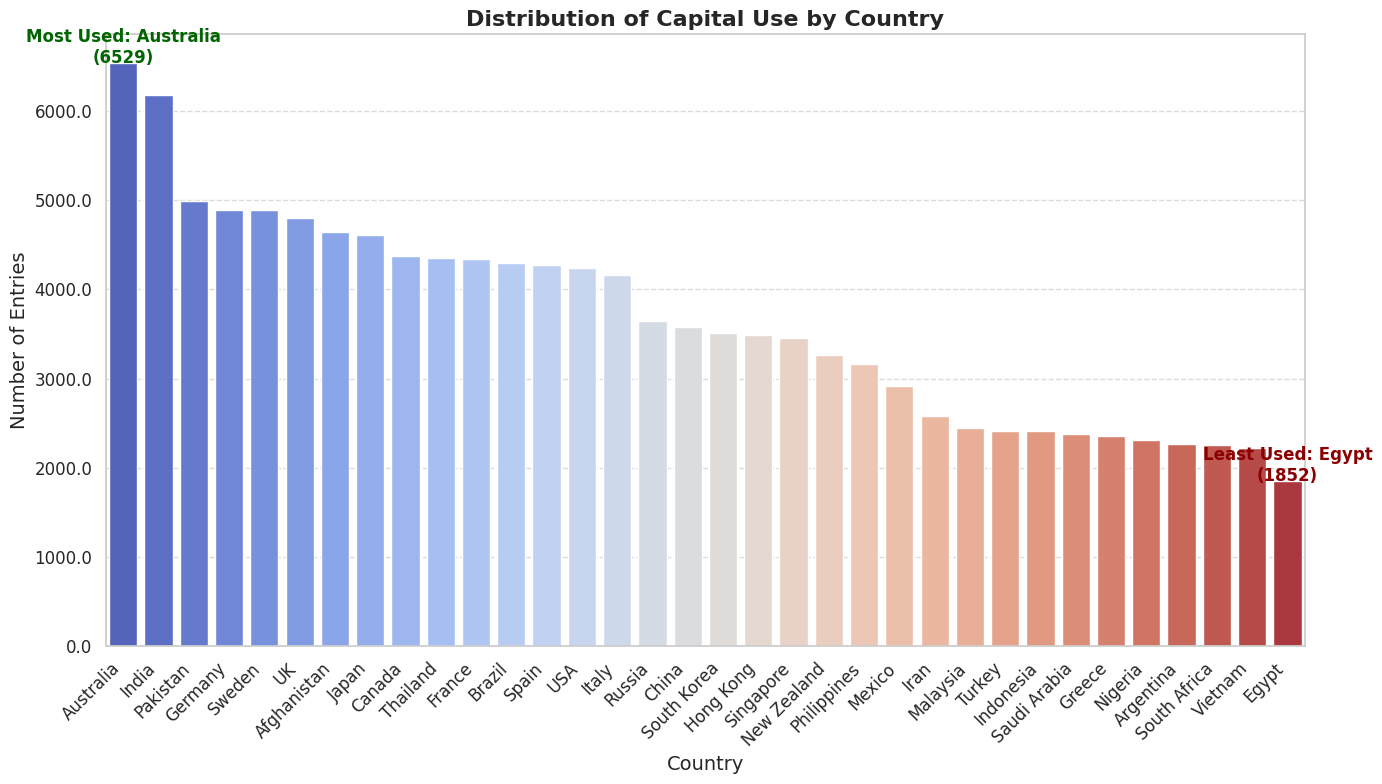

In [53]:
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Create a bar plot with a color palette
barplot = sns.barplot(x='Country', y='Count', data=country_counts, palette='coolwarm')

# Add titles and labels
plt.title('Distribution of Capital Use by Country', fontsize=16, weight='bold')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Entries', fontsize=14)

# Customize the bar plot
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right', fontsize=12)
barplot.set_yticklabels(barplot.get_yticks(), fontsize=12)

# Annotate the most and least used countries
plt.text(most_used_country.name, most_used_country['Count'] + 2,
         f'Most Used: {most_used_country["Country"]}\n({most_used_country["Count"]})',
         color='darkgreen', ha='center', fontsize=12, weight='bold')

plt.text(least_used_country.name, least_used_country['Count'] + 2,
         f'Least Used: {least_used_country["Country"]}\n({least_used_country["Count"]})',
         color='darkred', ha='center', fontsize=12, weight='bold')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Word Frequency Distribution

In [54]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


<ipython-input-55-3851701519>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




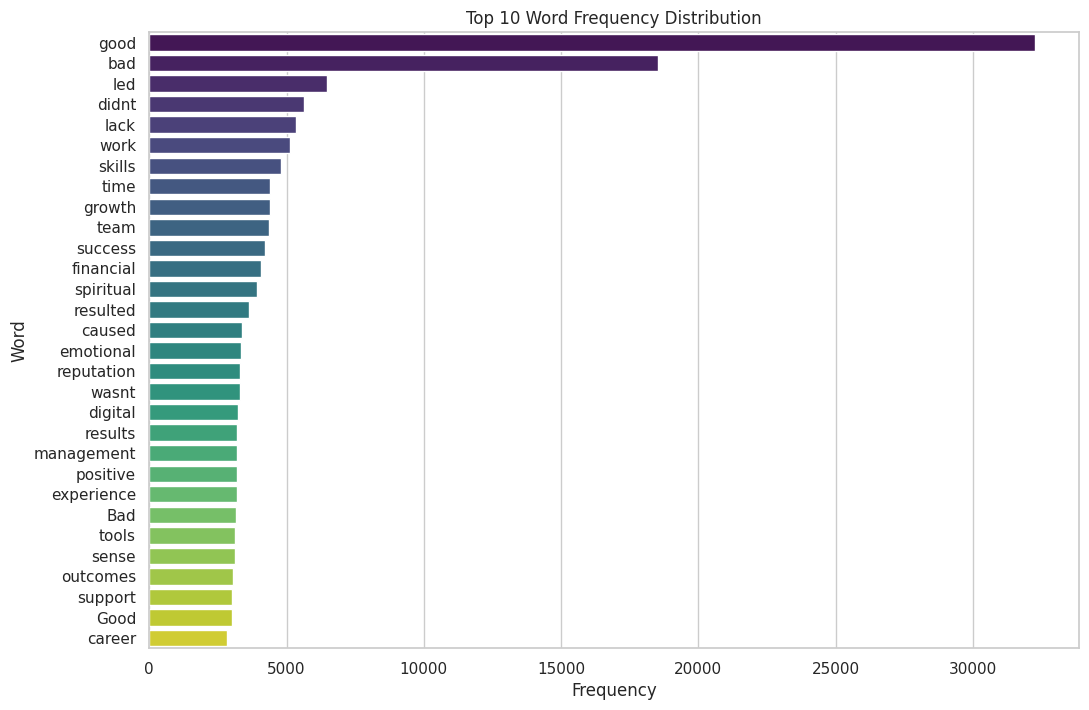

In [55]:
# Tokenize the words
all_words = word_tokenize(' '.join(df['Text_without_stopwords']))

# Get the frequency distribution
word_freq = FreqDist(all_words)

# Convert the frequency distribution to a DataFrame
word_freq_df = pd.DataFrame(word_freq.most_common(30), columns=['Word', 'Frequency'])

# Create a seaborn barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')

plt.title('Top 10 Word Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


In [57]:
print(df.columns)


Index(['Capitals Text Generation', 'Sentiment Label', 'Predicted Capital',
       'User-Id', 'Social-Accounts', 'Date', 'Time', 'Day', 'Country',
       'Age-Of-User', 'Clean_Capitals Text Generation', 'Tokens',
       'Normalized_text', 'Text_without_stopwords', 'text_length'],
      dtype='object')


# Plot Age-Of-User and Country Relation
This graph shows the distribution of ages for users in different countries

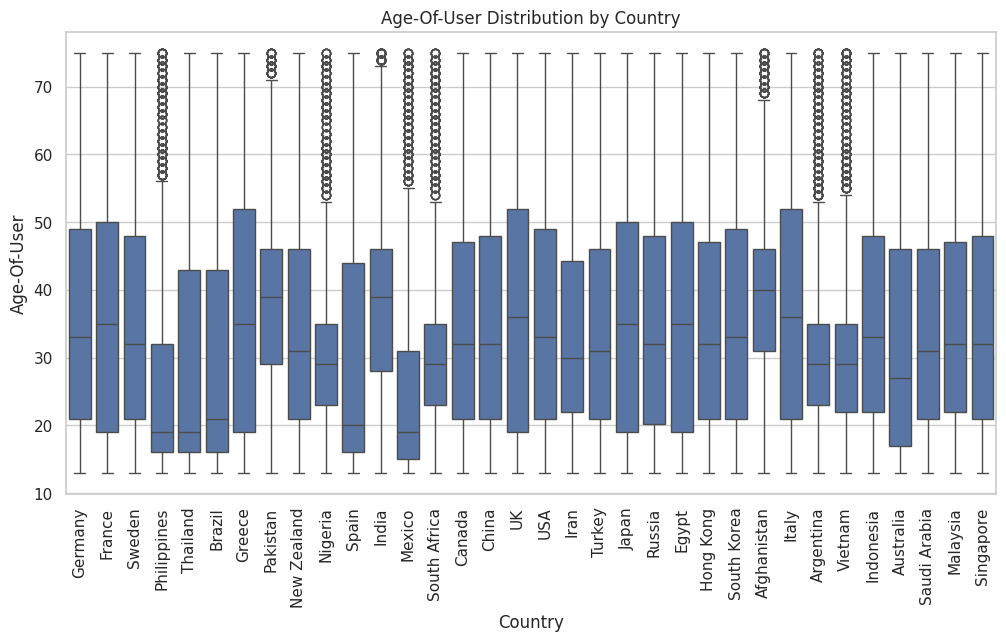

In [56]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='Age-Of-User', data=df)
plt.title('Age-Of-User Distribution by Country')
plt.xticks(rotation=90)
plt.show()

# Plot Age-Of-User and Predicted Capital Relation
This graph displays the distribution of user ages for each predicted capital type.
This helps in understanding which age groups are associated with which types of predicted capital.

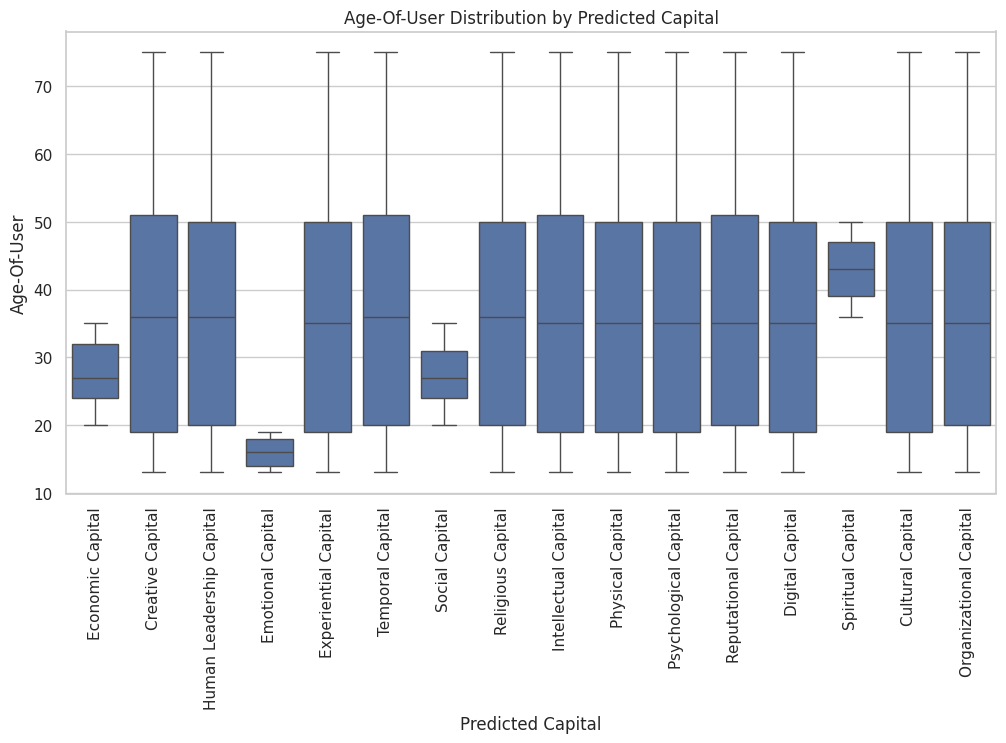

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Predicted Capital', y='Age-Of-User', data=df)
plt.title('Age-Of-User Distribution by Predicted Capital')
plt.xticks(rotation=90)
plt.show()

# Plot the count of Predicted Capital by Age-Of-User and Country
This graph shows the count of each type of predicted capital for each country. The hue differentiates the types of predicted capital, making it clear how many messages of each type are generated by users from different countries.
Helps in understanding the distribution and popularity of different capital types across countries, providing insights into geographical trends and cultural preferences.

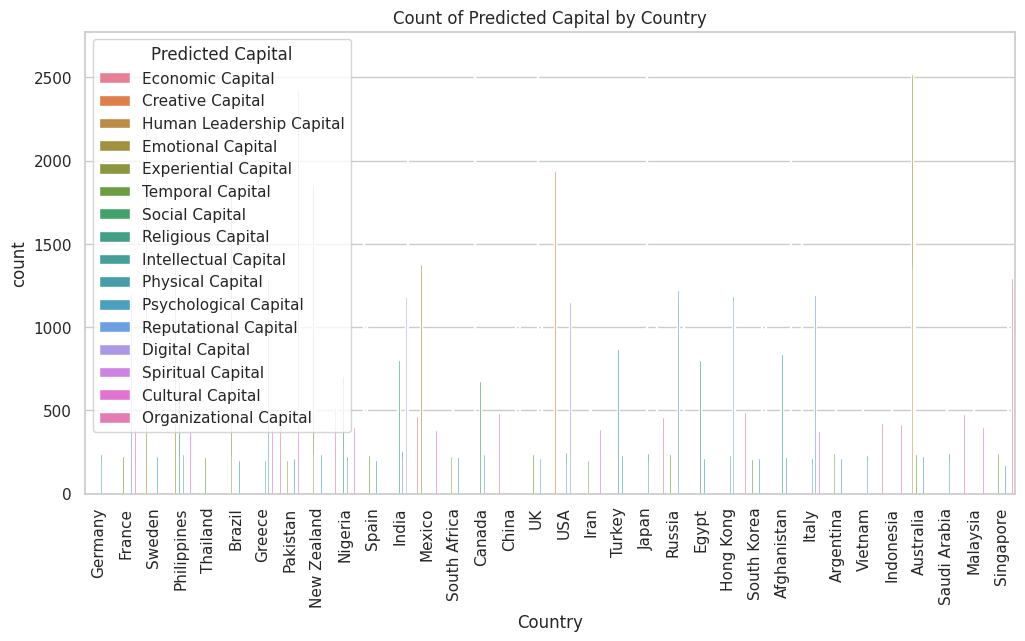

In [59]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Country', hue='Predicted Capital')
plt.title('Count of Predicted Capital by Country')
plt.xticks(rotation=90)
plt.show()

# Plot the count of Predicted Capital by Age-Of-User
## Purpose:
This histogram shows the count of each type of predicted capital for different ages. The stacking allows for a clear comparison of the distribution of capital types across different age groups.
## Usage:
Useful for identifying which age groups are most likely to generate specific types of capital messages, highlighting age-related trends in message generation.

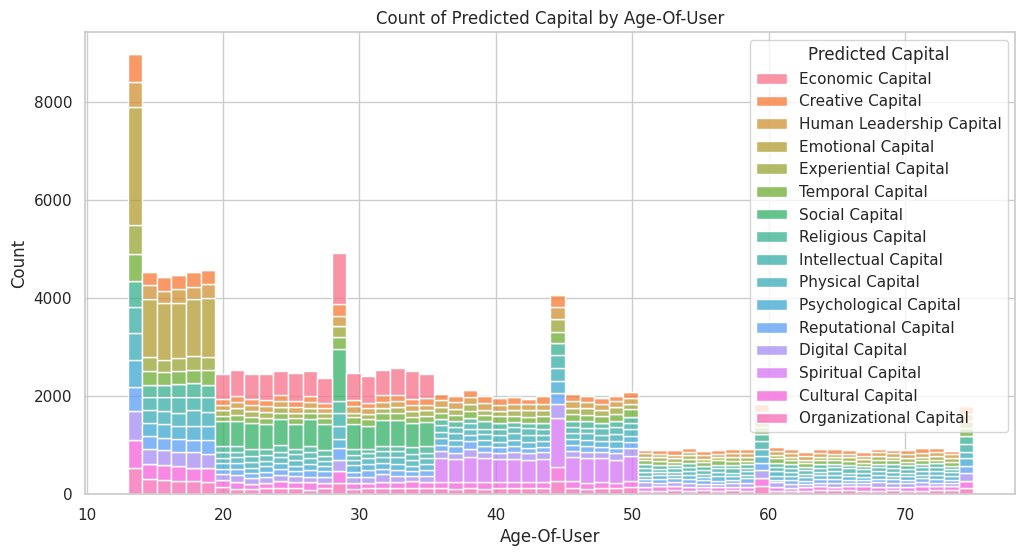

In [60]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age-Of-User', hue='Predicted Capital', multiple="stack")
plt.title('Count of Predicted Capital by Age-Of-User')
plt.show()

# Prepare Features and Labels

In [61]:
X = df['Text_without_stopwords']
y = df[['Predicted Capital', 'Sentiment Label']].copy()

# Encode Labels

In [62]:
label_encoder_capital_LSTM_WithoutGS = LabelEncoder()
label_encoder_sentiment_LSTM_WithoutGS = LabelEncoder()
y['Capital'] = label_encoder_capital_LSTM_WithoutGS.fit_transform(y['Predicted Capital'])
y['Sentiment'] = label_encoder_sentiment_LSTM_WithoutGS.fit_transform(y['Sentiment Label'])

# Split the dataset

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
y_train_sentiment = to_categorical(y_train['Sentiment'])
y_test_sentiment = to_categorical(y_test['Sentiment'])

In [65]:
y_train_sentiment

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [66]:
y_test_sentiment

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

# Step 2: Feature Extraction

# Tokenization and Padding for Sentiment Model

In [67]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [68]:
tokenizer_LSTM_WithoutGS = Tokenizer(num_words=15000, lower=True, split=' ')
tokenizer_LSTM_WithoutGS.fit_on_texts(X_train.values)
X_train_seq = tokenizer_LSTM_WithoutGS.texts_to_sequences(X_train.values)
X_test_seq = tokenizer_LSTM_WithoutGS.texts_to_sequences(X_test.values)
X_train_pad = pad_sequences(X_train_seq, maxlen=150)
X_test_pad = pad_sequences(X_test_seq, maxlen=X_train_pad.shape[1])

# Define Sentiment Model
### Sequential+Lstm

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout

In [70]:
sentiment_model_LSTM_WithoutGS = Sequential()
sentiment_model_LSTM_WithoutGS.add(Embedding(input_dim=15000, output_dim=128))
sentiment_model_LSTM_WithoutGS.add(SpatialDropout1D(0.3))
sentiment_model_LSTM_WithoutGS.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
sentiment_model_LSTM_WithoutGS.add(Dropout(0.5))
sentiment_model_LSTM_WithoutGS.add(Dense(y_train_sentiment.shape[1], activation='softmax'))

# Compile Sentiment Model

In [71]:
sentiment_model_LSTM_WithoutGS.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Sentiment Model

In [68]:
history = sentiment_model_LSTM_WithoutGS.fit(X_train_pad, y_train_sentiment, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test_sentiment), verbose=2)

Epoch 1/5
8401/8401 - 1695s - 202ms/step - accuracy: 0.9576 - loss: 0.1050 - val_accuracy: 0.9839 - val_loss: 0.0394
Epoch 2/5
8401/8401 - 1681s - 200ms/step - accuracy: 0.9849 - loss: 0.0390 - val_accuracy: 0.9909 - val_loss: 0.0211
Epoch 3/5
8401/8401 - 1668s - 199ms/step - accuracy: 0.9896 - loss: 0.0263 - val_accuracy: 0.9935 - val_loss: 0.0153
Epoch 4/5
8401/8401 - 1734s - 206ms/step - accuracy: 0.9916 - loss: 0.0202 - val_accuracy: 0.9941 - val_loss: 0.0135
Epoch 5/5
8401/8401 - 1680s - 200ms/step - accuracy: 0.9926 - loss: 0.0178 - val_accuracy: 0.9938 - val_loss: 0.0127


# Save the Sentiment Model and Tokenizer\

In [72]:
# Save the Keras model
sentiment_model_LSTM_WithoutGS.save('ssentiment_model_LSTM_WithoutGS.keras')

# Save the tokenizer
with open('tokenizer_LSTM_WithoutGS.pkl', 'wb') as file:
    pickle.dump(tokenizer_LSTM_WithoutGS, file)

# Save the label encoders
with open('label_encoder_sentiment_LSTM_WithoutGS.pkl', 'wb') as f:
    pickle.dump(label_encoder_sentiment_LSTM_WithoutGS, f)

with open('label_encoder_capital_LSTM_WithoutGS.pkl', 'wb') as f:
    pickle.dump(label_encoder_capital_LSTM_WithoutGS, f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning:

You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.



# Load the Model

In [73]:
from tensorflow.keras.models import load_model

In [76]:
# Load the Keras model
sentiment_model_LSTM_WithoutGS = load_model('sentiment_model_LSTM.keras')

# Load the tokenizer
with open('tokenizer_LSTM_WithoutGS.pkl', 'rb') as file:
    tokenizer_LSTM_WithoutGS = pickle.load(file)

# Load the label encoder for sentiment
with open('label_encoder_sentiment_LSTM_WithoutGS.pkl', 'rb') as f:
    label_encoder_sentiment_LSTM_WithoutGS = pickle.load(f)


# Load the label encoder for capital
with open('label_encoder_capital_LSTM_WithoutGS.pkl', 'rb') as f:
    label_encoder_capital_LSTM_WithoutGS = pickle.load(f)

ValueError: File not found: filepath=sentiment_model_LSTM.keras. Please ensure the file is an accessible `.keras` zip file.

#  Evaluation of the Sentiment Model

In [75]:
y_pred_sentiment = sentiment_model_LSTM_WithoutGS.predict(X_test_pad)
y_pred_labels_sentiment = np.argmax(y_pred_sentiment, axis=1)
y_true_labels_sentiment = np.argmax(y_test_sentiment, axis=1)

776/776 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step


# Results
### Accuracy, Precision, Recall, F1 Score


In [77]:
accuracy = accuracy_score(y_true_labels_sentiment, y_pred_labels_sentiment)
precision = precision_score(y_true_labels_sentiment, y_pred_labels_sentiment, average='weighted')
recall = recall_score(y_true_labels_sentiment, y_pred_labels_sentiment, average='weighted')
f1 = f1_score(y_true_labels_sentiment, y_pred_labels_sentiment, average='weighted')

# Print metrics

In [78]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5150147124027571
Precision: 0.49796815922827015
Recall: 0.5150147124027571
F1 Score: 0.45398615402546105


In [79]:
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the metrics

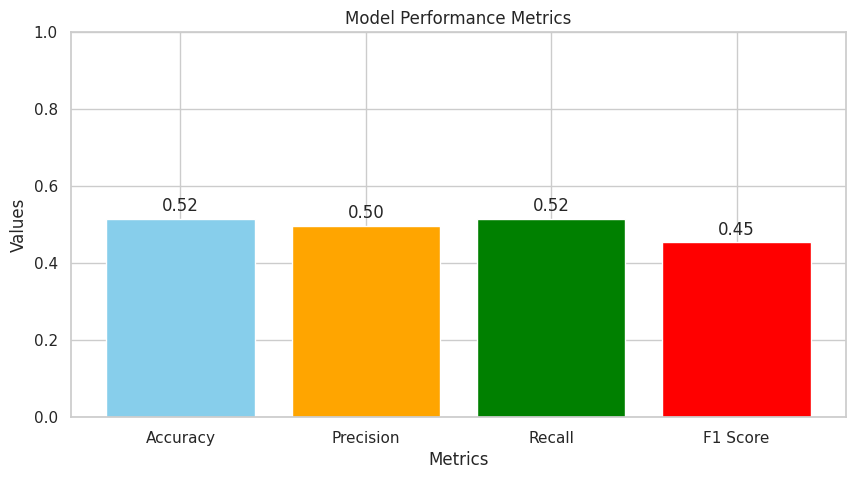

In [80]:
plt.figure(figsize=(10, 5))
plt.bar(metric_names, metrics, color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

# Classification Report

In [81]:
report_sentiment = classification_report(y_true_labels_sentiment, y_pred_labels_sentiment, target_names=label_encoder_sentiment_LSTM_WithoutGS.classes_)
print(f'Classification Report (Sentiment):\n{report_sentiment}')

Classification Report (Sentiment):
              precision    recall  f1-score   support

    Negative       0.47      0.17      0.24     11772
    Positive       0.52      0.83      0.64     13037

    accuracy                           0.52     24809
   macro avg       0.50      0.50      0.44     24809
weighted avg       0.50      0.52      0.45     24809



# Confusion Matrix Display for Sentiment

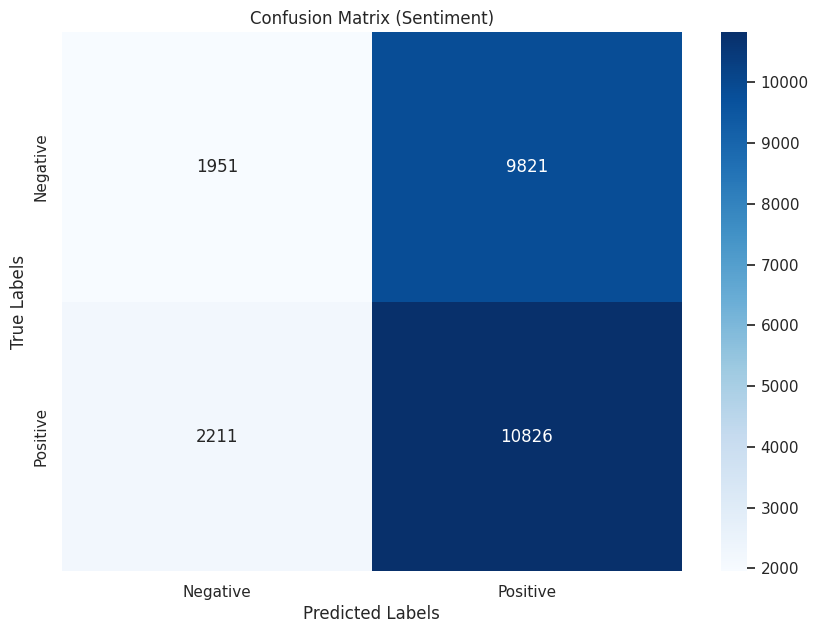

In [82]:
conf_matrix_sentiment = confusion_matrix(y_true_labels_sentiment, y_pred_labels_sentiment)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_sentiment, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_sentiment_LSTM_WithoutGS.classes_, yticklabels=label_encoder_sentiment_LSTM_WithoutGS.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Sentiment)')
plt.show()

# TF-IDF Vectorization for Capital Model

In [83]:
tfidf_vectorizer_LSTM_WithoutGS = TfidfVectorizer(max_features=15000)
X_train_tfidf = tfidf_vectorizer_LSTM_WithoutGS.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer_LSTM_WithoutGS.transform(X_test)

# Define Capital Model

In [84]:
capital_model_LSTM_WithoutGS = Sequential()
capital_model_LSTM_WithoutGS.add(Input(shape=(X_train_tfidf.shape[1],)))
capital_model_LSTM_WithoutGS.add(Dense(64, activation='relu'))
capital_model_LSTM_WithoutGS.add(Dense(len(label_encoder_capital_LSTM_WithoutGS.classes_), activation='softmax'))

# Compile Capital Model

In [85]:
capital_model_LSTM_WithoutGS.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Capital Model

In [86]:
capital_model_LSTM_WithoutGS.fit(X_train_tfidf, y_train['Capital'], epochs=5, batch_size=32, validation_data=(X_test_tfidf, y_test['Capital']), verbose=2)

Epoch 1/5
3102/3102 - 27s - 9ms/step - accuracy: 0.9575 - loss: 0.3380 - val_accuracy: 0.9949 - val_loss: 0.0296
Epoch 2/5
3102/3102 - 40s - 13ms/step - accuracy: 0.9974 - loss: 0.0162 - val_accuracy: 0.9977 - val_loss: 0.0120
Epoch 3/5
3102/3102 - 25s - 8ms/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 0.9983 - val_loss: 0.0067
Epoch 4/5
3102/3102 - 41s - 13ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9986 - val_loss: 0.0053
Epoch 5/5
3102/3102 - 26s - 8ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9987 - val_loss: 0.0054


# Evaluation of the Capital Model

In [87]:
y_pred_capital = capital_model_LSTM_WithoutGS.predict(X_test_tfidf)
y_pred_labels_capital = np.argmax(y_pred_capital, axis=1)
y_true_labels_capital = y_test['Capital']

776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


# Calculate metrics

In [88]:
accuracy = accuracy_score(y_true_labels_capital, y_pred_labels_capital)
precision = precision_score(y_true_labels_capital, y_pred_labels_capital, average='weighted')
recall = recall_score(y_true_labels_capital, y_pred_labels_capital, average='weighted')
f1 = f1_score(y_true_labels_capital, y_pred_labels_capital, average='weighted')

# Print metrics

In [89]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9986698375589503
Precision: 0.9986721430217952
Recall: 0.9986698375589503
F1 Score: 0.9986698323534077


In [90]:
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the metrics

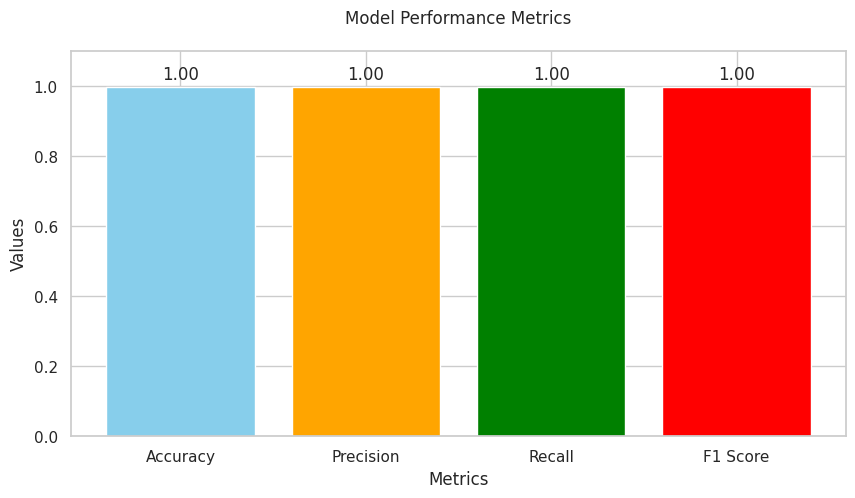

In [91]:
plt.figure(figsize=(10, 5))
plt.bar(metric_names, metrics, color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 1.1)  # Increase the upper limit slightly to allow space for text

# Adjust padding for the title to avoid overlap
plt.title('Model Performance Metrics', pad=20)

plt.xlabel('Metrics')
plt.ylabel('Values')

# Add the text annotations above the bars
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()

In [92]:
# plt.figure(figsize=(10, 5))
# plt.bar(metric_names, metrics, color=['skyblue', 'orange', 'green', 'red'])
# plt.ylim(0, 1)
# plt.title('Model Performance Metrics')
# plt.xlabel('Metrics')
# plt.ylabel('Values')
# for i, v in enumerate(metrics):
#     plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
# plt.show()

# Confusion Matrix of the Capital Model

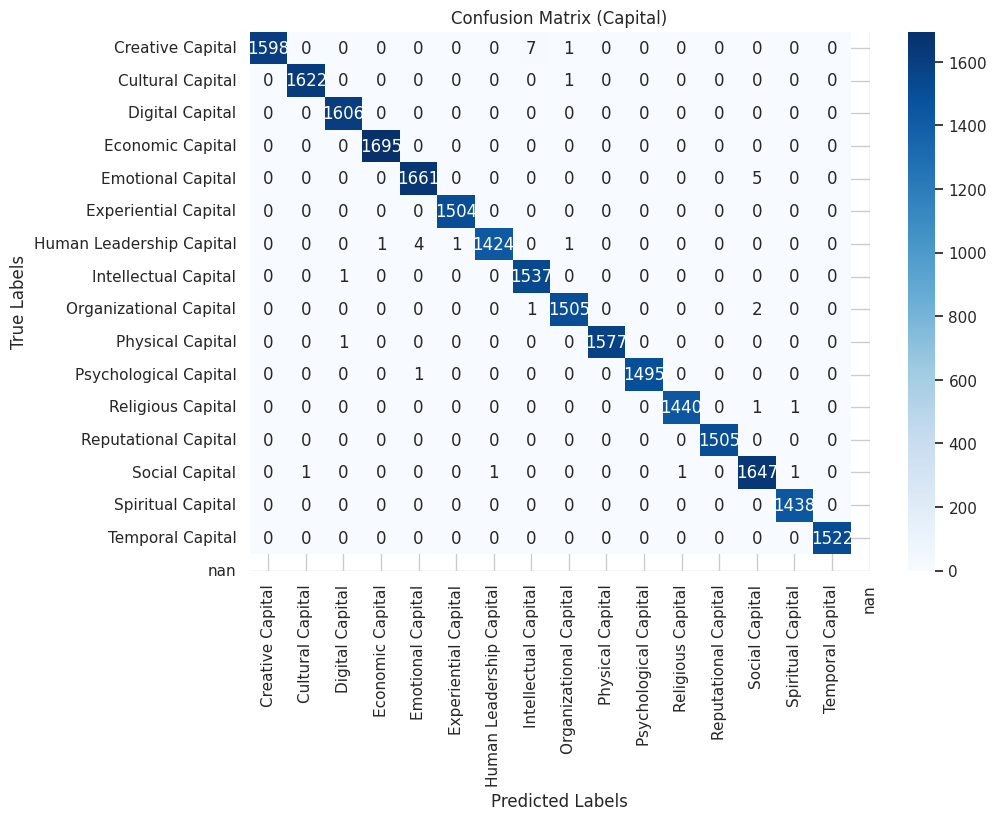

In [93]:
conf_matrix_capital = confusion_matrix(y_true_labels_capital, y_pred_labels_capital)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_capital, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_capital_LSTM_WithoutGS.classes_, yticklabels=label_encoder_capital_LSTM_WithoutGS.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Capital)')
plt.show()

# Save Capital Model and TF-IDF Vectorizer

In [94]:
# Save the Keras model
capital_model_LSTM_WithoutGS.save('capital_model_LSTM_WithoutGS.keras')

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer_LSTM_WithoutGS.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer_LSTM_WithoutGS, file)

# Save the label encoders
with open('label_encoder_capital_LSTM_WithoutGS.pkl', 'wb') as f:
    pickle.dump(label_encoder_capital_LSTM_WithoutGS, f)

with open('label_encoder_sentiment_LSTM_WithoutGS.pkl', 'wb') as f:
    pickle.dump(label_encoder_sentiment_LSTM_WithoutGS, f)

# Load model

In [95]:
# Load the Keras model
capital_model_LSTM_WithoutGS = load_model('capital_model_LSTM_WithoutGS.keras')

# Load the TF-IDF vectorizer
with open('tfidf_vectorizer_LSTM_WithoutGS.pkl', 'rb') as file:
    tfidf_vectorizer_LSTM_WithoutGS = pickle.load(file)

# Load the label encoder for capital
with open('label_encoder_capital_LSTM_WithoutGS.pkl', 'rb') as f:
    label_encoder_capital_LSTM_WithoutGS = pickle.load(f)

# Load the label encoder for sentiment
with open('label_encoder_sentiment_LSTM_WithoutGS.pkl', 'rb') as f:
    label_encoder_sentiment_LSTM_WithoutGS = pickle.load(f)

# Step 3: Prediction Pipeline

In [96]:
def predict_pipeline(text):
    clean_text = remove_unnecessary_characters(text)
    tokens = tokenize_text(clean_text)
    text_without_stopwords = ' '.join([word for word in tokens if word.lower() not in stop_words])
    text_tfidf = tfidf_vectorizer_LSTM_WithoutGS.transform([text_without_stopwords])

    capital_prediction_encoded = capital_model_LSTM_WithoutGS.predict(text_tfidf).argmax(axis=1)
    text_seq = tokenizer_LSTM_WithoutGS.texts_to_sequences([text_without_stopwords])
    text_pad = pad_sequences(text_seq, maxlen=X_train_pad.shape[1])
    sentiment_prediction_encoded = sentiment_model_LSTM_WithoutGS.predict(text_pad).argmax(axis=1)

    capital_prediction = label_encoder_capital_LSTM_WithoutGS.inverse_transform(capital_prediction_encoded)[0]
    sentiment_prediction = label_encoder_sentiment_LSTM_WithoutGS.inverse_transform(sentiment_prediction_encoded)[0]

    return capital_prediction, sentiment_prediction


# Test Prediction

In [97]:
test_sentence = "the financial state of country is bad"
capital, sentiment = predict_pipeline(test_sentence)
print(f"Predicted Capital: {capital}, Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Capital: Economic Capital, Predicted Sentiment: Positive


# GUI for Sentiment Prediction

In [98]:
import tkinter as tk
from tkinter import simpledialog, messagebox

In [103]:
import gradio as gr

def predict_ui(text):
    capital, sentiment = predict_pipeline(text)
    return f"Capital: {capital}", f"Sentiment: {sentiment}"

iface = gr.Interface(fn=predict_ui,
                     inputs=gr.Textbox(lines=2, placeholder="Enter your sentence here..."),
                     outputs=["text", "text"],
                     title="Capital and Sentiment Prediction")

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f398f077c0d47ac0d7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Thank You!